In [39]:
import tensorflow as tf
import keras
import os
import cv2
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [16]:
def get_last_layer_output():
    '''
    this function will return output of InceptionV3 model of desired layer to which
    more layers will be added as per requirements.
    '''
    
    pre_trained_model = InceptionV3(
    #do not include top layer "to be added later"
        include_top = False,
        input_shape=(150,150,3)
    )
    
    #use pre-trained weights by making most of the layers un-trainable
    for layer in pre_trained_model.layers:
        layer.trainable = False
    #used mixed7 layer as model architecture is pretty big and we dont need that much. 
    last_layer = pre_trained_model.get_layer('mixed7')
    print('last layer output shape: ', last_layer.output_shape)
    last_output = last_layer.output
    return last_output,pre_trained_model
    
    
    

In [17]:
def get_model():
    '''
    This function will return model by adding new layers to
    pre-trained InceptionV3 model using fuctional API model present in Keras.
    '''
    
    last_output, pre_trained_model = get_last_layer_output()
    #Flattened last layer output to feed into dense layer.
    x = tf.keras.layers.Flatten()(last_output)
       
    x = tf.keras.layers.Dense(units=1024,activation='relu')(x)
    
    #dropout to add regularisation
    x = tf.keras.layers.Dropout(0.3)(x)
    
    
    x = tf.keras.layers.Dense(units=1,activation='sigmoid')(x)

    model = Model(pre_trained_model.input,x)
    
    #used binary crossentropy as it is a binary classifier
    model.compile(loss='binary_crossentropy',metrics=['acc'],optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    
    return model

In [18]:
model=get_model()

last layer output shape:  (None, 7, 7, 768)


In [19]:
train_path=r'dataset\train'
validation_path=r'dataset\validation'

In [20]:
def train_test_generator(train_path,test_path):
    '''
    This fucntion will return training and testing 
    Image data generator objects provided by tensorflow which is used to
    do run time data augmentation.
    Also we do not need to label our data while using ImageDataGenerator 
    this is automatically done by TensorFlow based on folders.
    '''
    
    
    train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range = 40, #range of random rotation on data in degree
                                   width_shift_range = 0.2, #shift in width of image
                                   height_shift_range = 0.2, #shift in height of image
                                   shear_range = 0.2, #shearing is fixing image at one end and then streaching it an angle known as shear angle
                                   zoom_range = 0.2, 
                                   horizontal_flip = True #fipping images horizontally
                    )

    # Note that the validation data should not be augmented!
    test_datagen = ImageDataGenerator(rescale=1./255 )

    # Flow training images in batches of 100 using train_datagen generator
    train_generator = train_datagen.flow_from_directory(
        train_path, #path of directory
        batch_size = 100, 
        target_size = (150,150), #size of image required
        class_mode = 'binary' #no of classes

    )  
    # Flow training images in batches of 20 using validation_datagen generator
    validation_generator =  test_datagen.flow_from_directory( 
        validation_path,
        batch_size = 20,
        target_size = (150,150),
        class_mode = 'binary',
        shuffle=False
    )
     
    return train_generator, validation_generator

In [21]:
train_generator, validation_generator = train_test_generator(train_path,validation_path)

Found 3432 images belonging to 2 classes.
Found 414 images belonging to 2 classes.


In [46]:
#just to check consistency
print(train_generator.class_indices)
print(validation_generator.class_indices)

{'with_mask': 0, 'without_mask': 1}
{'with_mask': 0, 'without_mask': 1}


In [22]:
class CallBack(tf.keras.callbacks.Callback):
    '''
    A callback is an object that can perform actions at various stages of training
    (e.g. at the start or end of an epoch, before or after a single batch, etc).
    Callbacks are useful to get a view on internal states and statistics of the model during training.
    '''
    
    #used constructor to take manual input of thresholds.
    def __init__(self, threshold1, threshold2):
        self.train_threshold = threshold1
        self.val_threshold = threshold2
        
    #what actions to perform after every epoch
        
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('val_acc') > self.val_threshold and logs.get('acc') > self.train_threshold:
            print('Reached defined threshold')
            self.model.stop_training=True
    

In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch=35,
    epochs=30,
    verbose=2,
    callbacks=[CallBack(0.99, 0.992)],
    validation_data=validation_generator,
    validation_steps=21
)

Epoch 1/30


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


35/35 - 97s - loss: 0.4938 - acc: 0.9228 - val_loss: 0.1021 - val_acc: 0.9903
Epoch 2/30
35/35 - 103s - loss: 0.0736 - acc: 0.9770 - val_loss: 0.0754 - val_acc: 0.9928
Epoch 3/30
35/35 - 106s - loss: 0.0486 - acc: 0.9828 - val_loss: 0.0678 - val_acc: 0.9903
Epoch 4/30
35/35 - 96s - loss: 0.0411 - acc: 0.9860 - val_loss: 0.0587 - val_acc: 0.9928
Epoch 5/30
35/35 - 98s - loss: 0.0334 - acc: 0.9895 - val_loss: 0.0452 - val_acc: 0.9952
Epoch 6/30
35/35 - 102s - loss: 0.0386 - acc: 0.9878 - val_loss: 0.0450 - val_acc: 0.9952
Epoch 7/30
35/35 - 112s - loss: 0.0355 - acc: 0.9886 - val_loss: 0.0417 - val_acc: 0.9952
Epoch 8/30
35/35 - 97s - loss: 0.0270 - acc: 0.9895 - val_loss: 0.0435 - val_acc: 0.9928
Epoch 9/30
35/35 - 99s - loss: 0.0336 - acc: 0.9889 - val_loss: 0.0454 - val_acc: 0.9928
Epoch 10/30
35/35 - 99s - loss: 0.0339 - acc: 0.9866 - val_loss: 0.0491 - val_acc: 0.9928
Epoch 11/30
Reached defined threshold
35/35 - 96s - loss: 0.0272 - acc: 0.9921 - val_loss: 0.0471 - val_acc: 0.9928


In [ ]:
#model = tf.keras.models.load_model('classifier')

<h3>Plotting acc vs epochs and loss vs epochs to evaluate model </h3>

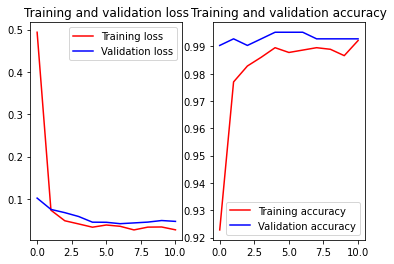

<Figure size 1440x864 with 0 Axes>

In [30]:


%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.subplot(1,2,2)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)


plt.figure(figsize = (20,12))

plt.show()

In [40]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [47]:
prediction=model.predict(validation_generator)
prediction=list(map(lambda x : 0 if x < 0.5 else 1, prediction))
cm=confusion_matrix(validation_generator.classes, prediction)
cm_plot_labels = ['with_mask','without_mask']

Confusion matrix, without normalization
[[203   1]
 [  2 208]]


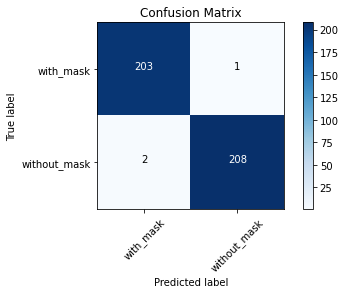

In [42]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix') #can be used to calculate values metrices like precision recall

# Saving model to save time

In [48]:
tf.keras.models.save_model(model,r'classifier.h5',save_format='h5')